In [ ]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

Сначала нужно залить файлы в хранилище CoLab

In [ ]:
df = pd.read_csv('appeal_citizens (1).csv')
print(len(df))
df

8557


,id,text_appeal,adress,home,text_appeal_lem,type,lat,lng,created_at,updated_at
0,10000,Тротуар возле рощи,улица Советская,50А,"""['тротуар', 'возле', 'роща']""",Need for a road,NaN,NaN,2021-10-30 11:06:19,2021-10-30 20:44:22
1,10001,прошу асфальтировать тротуар по улице Кукшумск...,улица Кукшумская,9,"""['просить', 'асфальтировать', 'тротуар', 'ули...",General improvement,56.087348,47.273998,2021-10-30 11:06:19,2021-10-30 20:44:22
2,10002,прошу асфальтировать тротуар по улице Кукшумск...,улица Кукшумская,9,"""['просить', 'асфальтировать', 'тротуар', 'ули...",General improvement,56.087348,47.273998,2021-10-30 11:06:19,2021-10-30 20:44:22
3,10003,"Бегают тараканы по всему подъезду, необходимо ...",улица Социалистическая,19,"""['бегать', 'таракан', 'весь', 'подъезд', 'нео...",General improvement,56.110093,47.179789,2021-10-30 11:06:19,2021-10-30 20:44:22
4,10004,Мы жильцы дома №7 живем с 1978 и капитального ...,улица Ахазова,7,"""['жилец', 'дом', '№', '7', 'жить', '1978', 'к...",General improvement,56.145380,47.174163,2021-10-30 11:06:19,2021-10-30 20:44:22
...,...,...,...,...,...,...,...,...,...,...
8552,18552,Озеленение территории микрорайона,улица Композитора А.М.Токарева,4,"""['озеленение', 'территория', 'микрорайон']""",Major overhaul,NaN,NaN,2021-10-30 11:06:53,2021-10-30 20:45:00
8553,18553,Благоустройство детской площадки и парковки во...,улица Эльменя,3,"""['благоустройство', 'детский', 'площадка', 'п...",Parking,NaN,NaN,2021-10-30 11:06:53,2021-10-30 20:45:00
8554,18554,Уборка мусора на территории дома 46. Новые ска...,улица Мичмана Павлова,46,"""['уборка', 'мусор', 'территория', 'дом', '46'...",Need for a road,NaN,NaN,2021-10-30 11:06:53,2021-10-30 20:45:00
8555,18555,Просим посодействовать в установке пандуса в п...,проспект Максима Горького,15,"""['просить', 'посодействовать', 'установка', '...",General improvement,NaN,NaN,2021-10-30 11:06:53,2021-10-30 20:45:00


In [ ]:
df.dropna(inplace = True)
df.reset_index(inplace = True)
print(len(df))
df

2488


,index,id,text_appeal,adress,home,text_appeal_lem,type,lat,lng,created_at,updated_at
0,1,10001,прошу асфальтировать тротуар по улице Кукшумск...,улица Кукшумская,9,"""['просить', 'асфальтировать', 'тротуар', 'ули...",General improvement,56.087348,47.273998,2021-10-30 11:06:19,2021-10-30 20:44:22
1,2,10002,прошу асфальтировать тротуар по улице Кукшумск...,улица Кукшумская,9,"""['просить', 'асфальтировать', 'тротуар', 'ули...",General improvement,56.087348,47.273998,2021-10-30 11:06:19,2021-10-30 20:44:22
2,3,10003,"Бегают тараканы по всему подъезду, необходимо ...",улица Социалистическая,19,"""['бегать', 'таракан', 'весь', 'подъезд', 'нео...",General improvement,56.110093,47.179789,2021-10-30 11:06:19,2021-10-30 20:44:22
3,4,10004,Мы жильцы дома №7 живем с 1978 и капитального ...,улица Ахазова,7,"""['жилец', 'дом', '№', '7', 'жить', '1978', 'к...",General improvement,56.145380,47.174163,2021-10-30 11:06:19,2021-10-30 20:44:22
4,7,10007,Навести порядок и обустроить место для ТБО.,проспект Ленина,25,"""['навещать', 'порядок', 'обустраивать', 'мест...",General improvement,56.124525,47.252694,2021-10-30 11:06:19,2021-10-30 20:44:23
...,...,...,...,...,...,...,...,...,...,...,...
2483,6349,16349,Прошу защитить работающих пенсионеров ветерано...,улица Кадыкова,8,"""['просить', 'защищать', 'работать', 'пенсионе...",General improvement,56.102176,47.292404,2021-10-30 11:06:44,2021-10-30 20:44:50
2484,6350,16350,"Побольше детских площадок, общественные туалеты",улица Первомайская,27А,"""['детский', 'площадка', 'общественный', 'туал...",General improvement,56.103732,47.179771,2021-10-30 11:06:44,2021-10-30 20:44:50
2485,6352,16352,"школу, парк",улица Эльменя,34,"""['школа', 'парк']""",school,56.123414,47.181667,2021-10-30 11:06:44,2021-10-30 20:44:50
2486,6353,16353,"Вопросы, связанные об оказании помощи детям во...",улица 324 Стрелковой дивизии,13,"""['вопрос', 'связывать', 'оказание', 'помощь',...",Need for a road,56.105753,47.288349,2021-10-30 11:06:44,2021-10-30 20:44:50


Выбираются только уникальные строки датафрейма

In [ ]:
unique_ident = []
unique_counter = []

for counter in range(len(df)):
    ident = df['adress'][counter] + ' ' + df['home'][counter] + ' ' + df['type'][counter]
    if ident not in unique_ident:
        unique_counter.append(counter)
        unique_ident.append(ident)

len(unique_counter)

1315

In [ ]:
df = df.iloc[unique_counter, :]
df.reset_index(inplace = True)
df

,level_0,index,id,text_appeal,adress,home,text_appeal_lem,type,lat,lng,created_at,updated_at
0,0,1,10001,прошу асфальтировать тротуар по улице Кукшумск...,улица Кукшумская,9,"""['просить', 'асфальтировать', 'тротуар', 'ули...",General improvement,56.087348,47.273998,2021-10-30 11:06:19,2021-10-30 20:44:22
1,2,3,10003,"Бегают тараканы по всему подъезду, необходимо ...",улица Социалистическая,19,"""['бегать', 'таракан', 'весь', 'подъезд', 'нео...",General improvement,56.110093,47.179789,2021-10-30 11:06:19,2021-10-30 20:44:22
2,3,4,10004,Мы жильцы дома №7 живем с 1978 и капитального ...,улица Ахазова,7,"""['жилец', 'дом', '№', '7', 'жить', '1978', 'к...",General improvement,56.145380,47.174163,2021-10-30 11:06:19,2021-10-30 20:44:22
3,4,7,10007,Навести порядок и обустроить место для ТБО.,проспект Ленина,25,"""['навещать', 'порядок', 'обустраивать', 'мест...",General improvement,56.124525,47.252694,2021-10-30 11:06:19,2021-10-30 20:44:23
4,5,8,10008,сделать дорогу,проспект Мира,ё,"""['сделать', 'дорога']""",Need for a road,56.123200,47.281117,2021-10-30 11:06:19,2021-10-30 20:44:23
...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2474,6340,16340,"Нужна детская площадка.\nЛестница опасная, сли...",улица Хузангая,40,"""['нужный', 'детский', 'площадка', 'лестница',...",Playground,56.088167,47.277501,2021-10-30 11:06:44,2021-10-30 20:44:50
1311,2475,6341,16341,"Ремонт в подъезде, заменить окна.",улица Ахазова,3,"""['ремонт', 'подъезд', 'заменять', 'окно']""",Major overhaul,56.145324,47.171675,2021-10-30 11:06:44,2021-10-30 20:44:50
1312,2483,6349,16349,Прошу защитить работающих пенсионеров ветерано...,улица Кадыкова,8,"""['просить', 'защищать', 'работать', 'пенсионе...",General improvement,56.102176,47.292404,2021-10-30 11:06:44,2021-10-30 20:44:50
1313,2484,6350,16350,"Побольше детских площадок, общественные туалеты",улица Первомайская,27А,"""['детский', 'площадка', 'общественный', 'туал...",General improvement,56.103732,47.179771,2021-10-30 11:06:44,2021-10-30 20:44:50


# Переведем координаты из широты и долготы в метры (в пределах города кривизной Земли можно пренебречь)

In [ ]:
'''Определим диапазоны изменения по широте и долготе'''
min_x, max_x = min(df['lat']), max(df['lat'])
print(min_x, max_x)
min_y, max_y = min(df['lng']), max(df['lng'])
print(min_y, max_y)

56.060091 56.199917000000006
47.149259 47.392848


Для нахождения диапазона изменения координат в пределах города используется сервис
https://livegpstracks.com/default.php?ch=converter#cnv2

Диапазон по lat - у нас координата 'x'
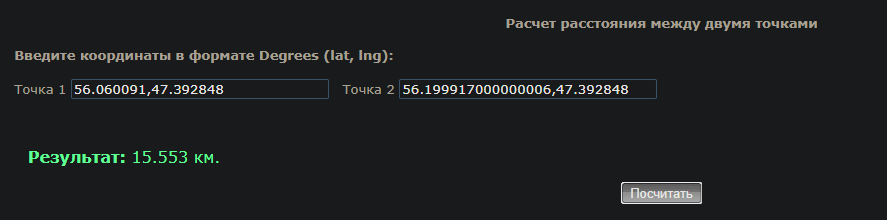

Диапазон по lng - у нас координата 'y'
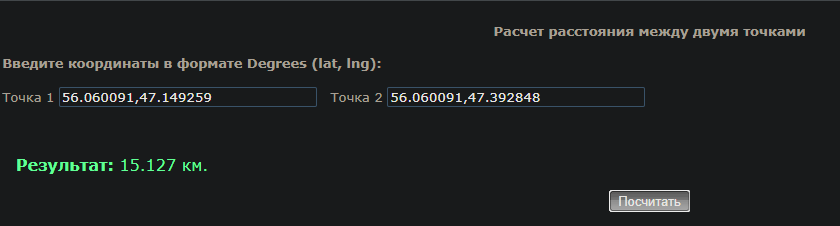

Определим коэффициенты скалирования координат

In [ ]:
def transform_coor(coor1, diap):
    coor = coor1.copy()
    coor -= min(coor)
    coor = coor / max(coor)
    coor = coor * diap
    return coor

In [ ]:
diap_x = 15.553
diap_y = 15.127

X, Y = df['lat'].values, df['lng'].values

X = transform_coor(X.copy(), diap_x)
Y = transform_coor(Y.copy(), diap_y)

df['X'] = X
df['Y'] = Y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df

,level_0,index,id,text_appeal,adress,home,text_appeal_lem,type,lat,lng,created_at,updated_at,X,Y
0,0,1,10001,прошу асфальтировать тротуар по улице Кукшумск...,улица Кукшумская,9,"""['просить', 'асфальтировать', 'тротуар', 'ули...",General improvement,56.087348,47.273998,2021-10-30 11:06:19,2021-10-30 20:44:22,3.031826,7.746355
1,2,3,10003,"Бегают тараканы по всему подъезду, необходимо ...",улица Социалистическая,19,"""['бегать', 'таракан', 'весь', 'подъезд', 'нео...",General improvement,56.110093,47.179789,2021-10-30 11:06:19,2021-10-30 20:44:22,5.561778,1.895928
2,3,4,10004,Мы жильцы дома №7 живем с 1978 и капитального ...,улица Ахазова,7,"""['жилец', 'дом', '№', '7', 'жить', '1978', 'к...",General improvement,56.145380,47.174163,2021-10-30 11:06:19,2021-10-30 20:44:22,9.486789,1.546551
3,4,7,10007,Навести порядок и обустроить место для ТБО.,проспект Ленина,25,"""['навещать', 'порядок', 'обустраивать', 'мест...",General improvement,56.124525,47.252694,2021-10-30 11:06:19,2021-10-30 20:44:23,7.167065,6.423366
4,5,8,10008,сделать дорогу,проспект Мира,ё,"""['сделать', 'дорога']""",Need for a road,56.123200,47.281117,2021-10-30 11:06:19,2021-10-30 20:44:23,7.019684,8.188448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2474,6340,16340,"Нужна детская площадка.\nЛестница опасная, сли...",улица Хузангая,40,"""['нужный', 'детский', 'площадка', 'лестница',...",Playground,56.088167,47.277501,2021-10-30 11:06:44,2021-10-30 20:44:50,3.122924,7.963893
1311,2475,6341,16341,"Ремонт в подъезде, заменить окна.",улица Ахазова,3,"""['ремонт', 'подъезд', 'заменять', 'окно']""",Major overhaul,56.145324,47.171675,2021-10-30 11:06:44,2021-10-30 20:44:50,9.480560,1.392045
1312,2483,6349,16349,Прошу защитить работающих пенсионеров ветерано...,улица Кадыкова,8,"""['просить', 'защищать', 'работать', 'пенсионе...",General improvement,56.102176,47.292404,2021-10-30 11:06:44,2021-10-30 20:44:50,4.681161,8.889377
1313,2484,6350,16350,"Побольше детских площадок, общественные туалеты",улица Первомайская,27А,"""['детский', 'площадка', 'общественный', 'туал...",General improvement,56.103732,47.179771,2021-10-30 11:06:44,2021-10-30 20:44:50,4.854237,1.894811


In [ ]:
# for type_data in df['type'].unique():
#     x, y = df[df['type'] == type_data]['X'].values, df[df['type'] == type_data]['Y'].values   
#     plt.figure()
#     plt.scatter(x, y)
#     plt.title(type_data)

In [ ]:
list_types = list(df['type'].unique())[1:]
list_eps = [0.5, 0.15, 1, 0.3, 1]
list_min_samples = [6, 2, 2, 2, 2]

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
clusters_id = []
type_clust = []
list_lat = []
list_lng = []
list_X = []
list_Y = []

for counter in range(len(list_types)):
    '''Обучаем модель по текущим условиям'''
    type_data = list_types[counter]
    eps = list_eps[counter]
    min_samples = list_min_samples[counter]

    clustering = DBSCAN(eps=eps, min_samples=min_samples)
  
    df_type = df[df['type'] == type_data]

    x, y = df_type['X'].values, df_type['Y'].values 
    data = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
    clustering.fit(data)

    '''Список уникальных кластеров'''
    list_labels = list(set(clustering.labels_))
    list_labels.remove(-1)

    for label in list_labels:
        df_label = df_type[clustering.labels_ == label]
        id = df_label['id'].values
        lat = np.mean(df_label['lat'].values)
        lng = np.mean(df_label['lng'].values)
        X_m = np.mean(df_label['X'].values)
        Y_m = np.mean(df_label['Y'].values)

        clusters_id.append(list(id))
        type_clust.append(type_data)
        list_lat.append(lat)
        list_lng.append(lng)
        list_X.append(X_m)
        list_Y.append(Y_m)

In [ ]:
data = {'type':type_clust, 'ids':clusters_id, 'lat':list_lat, 'lng':list_lng, 'X':list_X, 'Y':list_Y}
df_output = pd.DataFrame(data)
df_output['id'] = df_output.index
df_output

,type,ids,lat,lng,X,Y,id
0,Need for a road,"[10008, 10014, 10063, 10077, 10268, 10423, 104...",56.127721,47.276869,7.522529,7.924631,0
1,Need for a road,"[10015, 10026, 10041, 10088, 10099, 10113, 101...",56.103770,47.273974,4.858459,7.744858,1
2,Need for a road,"[10023, 11199, 11400, 12024, 12063, 12099, 12760]",56.069861,47.224157,1.086760,4.651204,2
3,Need for a road,"[10025, 10027, 10043, 10110, 10125, 10138, 102...",56.116352,47.186525,6.258020,2.314257,3
4,Need for a road,"[10050, 10086, 10270, 10574, 10968, 11136, 112...",56.145116,47.177173,9.457453,1.733499,4
...,...,...,...,...,...,...,...
81,Parking,"[10040, 10102, 10212, 10876, 11986, 12421, 126...",56.102923,47.298266,4.764263,9.253424,81
82,Parking,"[10209, 11069, 11118, 12038, 13000, 13085, 13309]",56.121765,47.188015,6.860035,2.406776,82
83,Parking,"[10235, 11373, 13334, 16146]",56.125308,47.269514,7.254159,7.467881,83
84,Parking,"[10720, 12886, 16228]",56.145720,47.176644,9.524608,1.700643,84


In [ ]:
tec_output = df_output[df_output['type'] == 'school']
tec_output
# X_centroid, Y_centroid

,type,ids,lat,lng,X,Y,id
51,school,"[10017, 11918, 11963]",56.123621,47.180390,7.066512,1.933251,51
52,school,"[10692, 10937, 11432, 11656, 11873]",56.116233,47.216287,6.244737,4.162448,52


17
34
2
28
5


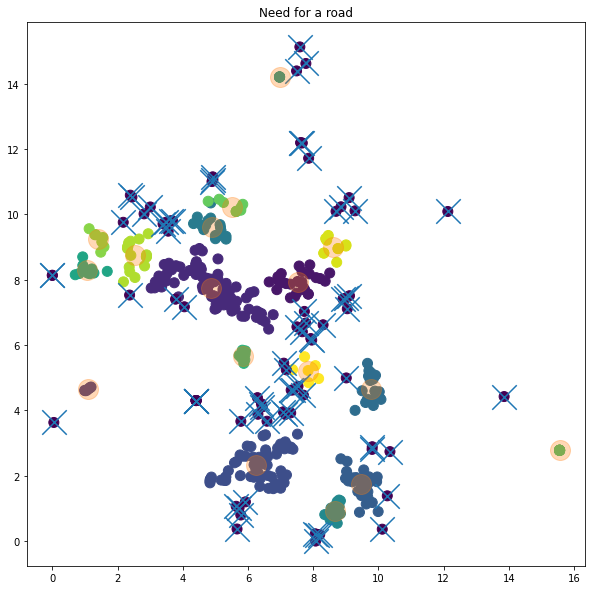

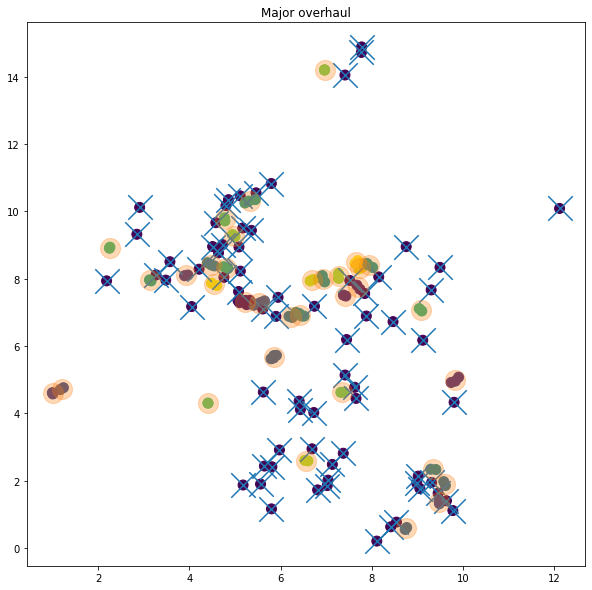

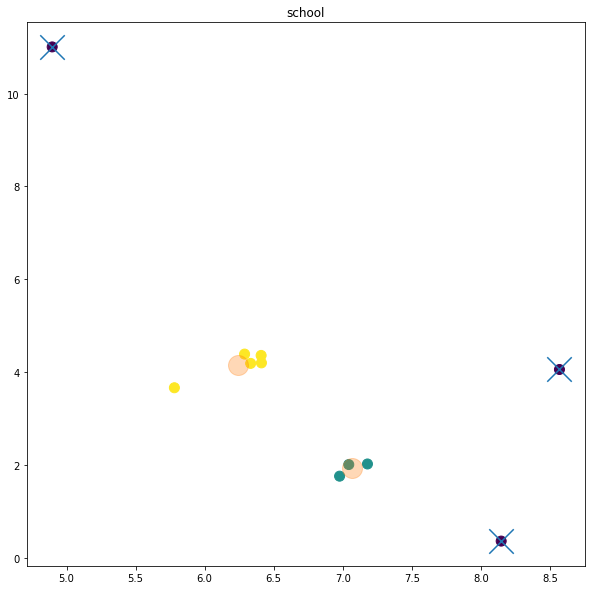

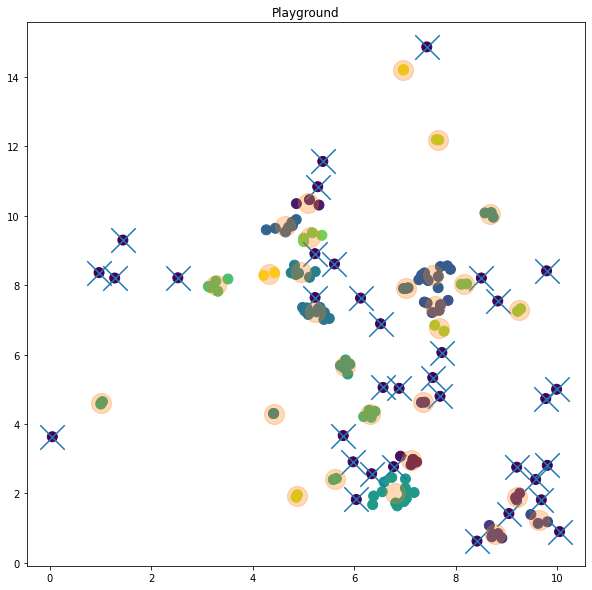

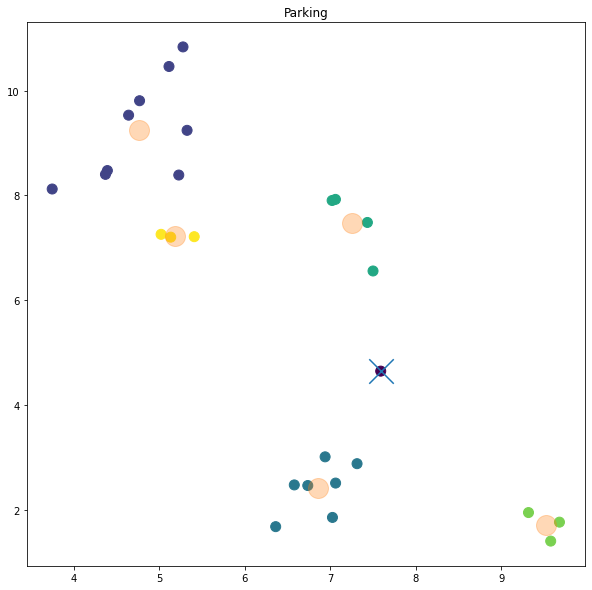

In [ ]:
for counter in range(len(list_types)):
    type_data = list_types[counter]
    eps = list_eps[counter]
    min_samples = list_min_samples[counter]

    tec_output = df_output[df_output['type'] == type_data]
    X_centroid, Y_centroid = tec_output['X'].values, tec_output['Y'].values

    clustering = DBSCAN(eps=eps, min_samples=min_samples)
    x, y = df[df['type'] == type_data]['X'].values, df[df['type'] == type_data]['Y'].values 
    data = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
    clustering.fit(data)
    plt.figure(figsize=(10, 10))
    plt.title(type_data)
    plt.scatter(data[:, 0], data[:,1], c = clustering.labels_, s = 100)
    plt.scatter(data[clustering.labels_ == -1][:, 0], data[clustering.labels_ == -1][:, 1], s = 600, marker = 'x')   
    plt.scatter(X_centroid, Y_centroid, s = 400, alpha = 0.3) 
    
    print(len(set(clustering.labels_))-1)

In [ ]:
df_output.drop(columns = ['X', 'Y'], inplace = True)
df_output

,type,ids,lat,lng,id
0,Need for a road,"[10008, 10014, 10063, 10077, 10268, 10423, 104...",56.127721,47.276869,0
1,Need for a road,"[10015, 10026, 10041, 10088, 10099, 10113, 101...",56.103770,47.273974,1
2,Need for a road,"[10023, 11199, 11400, 12024, 12063, 12099, 12760]",56.069861,47.224157,2
3,Need for a road,"[10025, 10027, 10043, 10110, 10125, 10138, 102...",56.116352,47.186525,3
4,Need for a road,"[10050, 10086, 10270, 10574, 10968, 11136, 112...",56.145116,47.177173,4
...,...,...,...,...,...
81,Parking,"[10040, 10102, 10212, 10876, 11986, 12421, 126...",56.102923,47.298266,81
82,Parking,"[10209, 11069, 11118, 12038, 13000, 13085, 13309]",56.121765,47.188015,82
83,Parking,"[10235, 11373, 13334, 16146]",56.125308,47.269514,83
84,Parking,"[10720, 12886, 16228]",56.145720,47.176644,84


In [ ]:
df_output.to_csv('Кластеризация.csv', encoding = 'utf-8', index= False)
df_check = pd.read_csv('Кластеризация.csv')
df_check.head(10)

,type,ids,lat,lng,id
0,Need for a road,"[10008, 10014, 10063, 10077, 10268, 10423, 104...",56.127721,47.276869,0
1,Need for a road,"[10015, 10026, 10041, 10088, 10099, 10113, 101...",56.103770,47.273974,1
2,Need for a road,"[10023, 11199, 11400, 12024, 12063, 12099, 12760]",56.069861,47.224157,2
3,Need for a road,"[10025, 10027, 10043, 10110, 10125, 10138, 102...",56.116352,47.186525,3
4,Need for a road,"[10050, 10086, 10270, 10574, 10968, 11136, 112...",56.145116,47.177173,4
5,Need for a road,"[10078, 10570, 10623, 10678, 10693, 10729, 107...",56.147910,47.224428,5
6,Need for a road,"[10067, 10106, 10276, 10439, 10477, 10517, 106...",56.104149,47.304139,6
7,Need for a road,"[10111, 10119, 10154, 10224, 10293, 10363, 105...",56.138003,47.164157,7
8,Need for a road,"[10142, 10437, 11830, 12072, 12293, 12947]",56.122730,47.378021,8
9,Need for a road,"[10145, 10351, 10589, 11622, 12131, 12707, 129...",56.069770,47.282958,9


In [ ]:
1

1